In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import warnings
from statistics import mode
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')

from keras.metrics import F1Score

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-10-11 12:26:38.279379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-11 12:26:38.304817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-11 12:26:38.312570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-11 12:26:38.332715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-11 12:26:41.439348: W tensorflow/compiler/tf2

In [2]:
test = pd.read_csv('../data_test_24-29.csv')
train = pd.read_csv('../data_train_24-29.csv')

In [3]:
train_data = train.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)
test_data = test.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)

In [4]:
train_data.dropna(axis=0, how='any', inplace=True)
print(train_data.shape)
test_data.dropna(axis=0, how='any', inplace=True)
print(test_data.shape)

(178283, 8)
(44574, 8)


In [5]:
n_time_steps = 104
n_features = 7
step = 104
n_classes = 5
n_epochs = 100
batch_size = 16
learning_rate = 0.0025
l2_loss = 0.0015
PATIENCE = 10

segments = []
labels = []

segments_test = []
labels_test = []

In [6]:
for i in range(0, train_data.shape[0] - n_time_steps, step):
    # Extracting segments for each sensor's data
    Ax_tr = train_data['Ax'].values[i: i + n_time_steps]
    Ay_tr = train_data['Ay'].values[i: i + n_time_steps]
    Az_tr = train_data['Az'].values[i: i + n_time_steps]
    Gx_tr = train_data['Gx'].values[i: i + n_time_steps]
    Gy_tr = train_data['Gy'].values[i: i + n_time_steps]
    Gz_tr = train_data['Gz'].values[i: i + n_time_steps]
    Speed_tr = train_data['Speed'].values[i: i + n_time_steps]

    # Extracting the label slice
    label_slice = train_data['Label'][i: i + n_time_steps]

    # Using Counter to get the mode of the label slice
    try:
        label_tr = Counter(label_slice).most_common(1)[0][0]
    except Exception as e:
        # If there's an error, print details for debugging
        print("Error at iteration:", i)
        print("Label slice causing error:", label_slice)
        print("Error message:", e)
        continue  

    # Appending the results to the segments and labels lists
    segments.append([Ax_tr, Ay_tr, Az_tr, Gx_tr,Gy_tr,Gz_tr,Speed_tr])
    labels.append(label_tr)

unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the count of cases for each label
for label, count in zip(unique_labels, label_counts):
    print("Label {}: {} cases".format(label, count))

Label BUMP: 126 cases
Label LEFT: 71 cases
Label RIGHT: 93 cases
Label STOP: 57 cases
Label STRAIGHT: 1367 cases


In [7]:
X_train = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
y_train = np.asarray(pd.get_dummies(labels), dtype = np.float32)
X_train.shape

(1714, 104, 7)

In [8]:
for i in range(0, test_data.shape[0] - n_time_steps, step):
    # Extracting segments for each sensor's data
    Ax_tr = test_data['Ax'].values[i: i + n_time_steps]
    Ay_tr = test_data['Ay'].values[i: i + n_time_steps]
    Az_tr = test_data['Az'].values[i: i + n_time_steps]
    Gx_tr = test_data['Gx'].values[i: i + n_time_steps]
    Gy_tr = test_data['Gy'].values[i: i + n_time_steps]
    Gz_tr = test_data['Gz'].values[i: i + n_time_steps]
    Speed_tr = test_data['Speed'].values[i: i + n_time_steps]

    # Extracting the label slice
    label_slice = test_data['Label'][i: i + n_time_steps]

    # Using Counter to get the mode of the label slice
    try:
        label_tr = Counter(label_slice).most_common(1)[0][0]
    except Exception as e:
        # If there's an error, print details for debugging
        print("Error at iteration:", i)
        print("Label slice causing error:", label_slice)
        print("Error message:", e)
        continue 

    # Appending the results to the segments and labels lists
    segments_test.append([Ax_tr, Ay_tr, Az_tr, Gx_tr,Gy_tr,Gz_tr,Speed_tr])
    labels_test.append(label_tr)

unique_test_labels, label_test_counts = np.unique(labels_test, return_counts=True)

# Print the count of cases for each label
for label, count in zip(unique_test_labels, label_test_counts):
    print("Label {}: {} cases".format(label, count))

Label BUMP: 31 cases
Label LEFT: 18 cases
Label RIGHT: 23 cases
Label STOP: 14 cases
Label STRAIGHT: 342 cases


In [9]:
X_test = np.asarray(segments_test, dtype= np.float32).reshape(-1, n_time_steps, n_features)
y_test = np.asarray(pd.get_dummies(labels_test), dtype = np.float32)
X_test.shape

(428, 104, 7)

In [10]:
model = Sequential()

# RNN layer
model.add(LSTM(units = 100, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 10, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))

# Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2025-10-11 12:26:48.324749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9616 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,265 (172.91 KB)

 Trainable params: 44,265 (172.91 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/100


2025-10-11 12:26:51.347889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7200 - loss: 0.9754
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8280 - loss: 0.6230
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8434 - loss: 0.4700
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8462 - loss: 0.4726
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8526 - loss: 0.4080
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8924 - loss: 0.3204
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9099 - loss: 0.2780
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9185 - loss: 0.2584
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9130 - loss: 0.2877
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9077 - loss: 0.2606
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9009 - loss: 0.2962
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9180 - loss: 0.4388  
Test Accuracy : 0.913551390171051
Test Loss : 0.4684467613697052


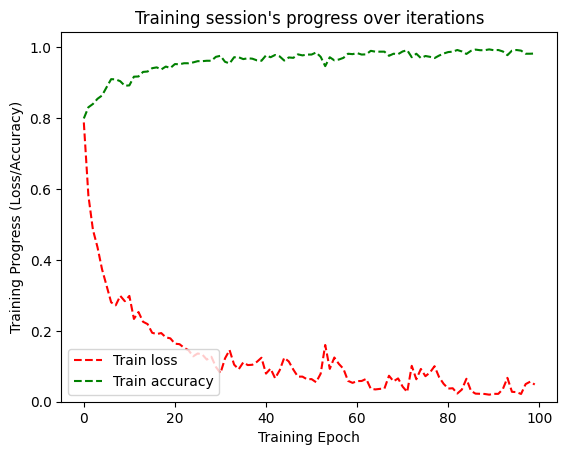

In [13]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Shape of y_pred is (428, 5)
Shape of y_pred_classes is (428,)
Shape of y_test_encoded is (428, 5)
Shape of y_test_categorical is (428,)


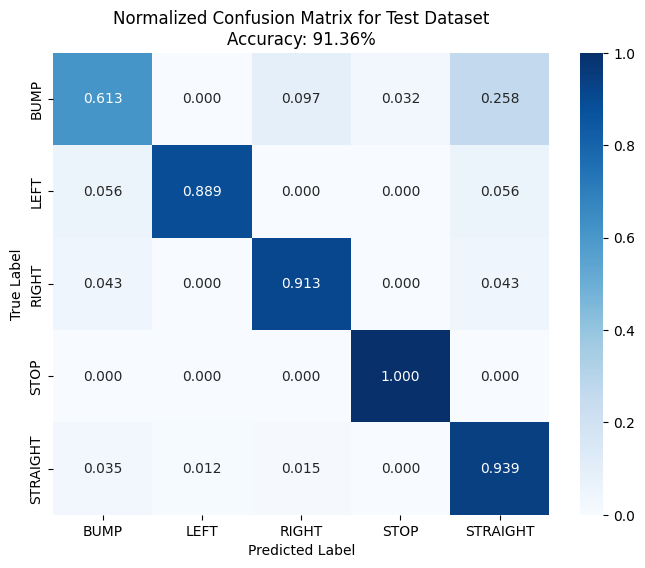

Accuracy:91.35514019%


In [20]:
# Get the class labels
classes = pd.get_dummies(labels).columns.tolist()

y_pred = model.predict(X_test, batch_size=batch_size)
print("Shape of y_pred is", y_pred.shape)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Shape of y_pred_classes is", y_pred_classes.shape)
y_test_categorical = np.argmax(y_test, axis=1)
print("Shape of y_test_encoded is", y_test.shape)
print("Shape of y_test_categorical is", y_test_categorical.shape)
conf_matrix = confusion_matrix(y_test_categorical, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Normalize the confusion matrix to get values between 0 and 1
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix for Test Dataset\nAccuracy: {:.2%}'.format(accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy:{accuracy*100:0.8f}%")

In [15]:
model.save_weights("lstm_model.weights.h5")  